#  Object detection (faster_rcnn)

## 1. Import packages

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os
import random
import math
import numpy as np
from collections import OrderedDict
import xml.etree.ElementTree as ET

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision.ops import misc as misc_nn_ops

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Funtion for visualization
def draw_bb(img, boxes, color='r', figsize=(8,8)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()
    
### Fuction for vislualize boudning with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='r', color2='g', figsize=(20,20)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes1:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

## 2. Define Pascal VOC dataloader

- Pascal VOC dataset folder structure

data/VOC2007/  

>ImageSets/Main/  
>>train.txt  
>>train_small.txt(optional)  

>JPEGImages/  
>>000005.jpg  
>>000007.jpg  
>>000009.jpg  
>>000012.jpg  
>>...  

>Annotations/  
>>000005.xml  
>>000007.xml  
>>000009.xml  
>>000012.xml  
>>...  

- PASCAL VOC image example : 

![PASCAL VOC SAMPLE IMAGE](./VOC2007/JPEGImages/000010.jpg)

### 2-1. Recap of the dataloader we define

In [3]:
class PascalDataset(data.Dataset):
    def __init__(self, voc_root, image_set, transforms):
        ### Data root, transform
        self.data_root = voc_root
        self.transforms = transforms        

        ### class name to class label mapping
        self._classes = ('__background__',
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
        self._class_to_ind = dict(zip(self._classes, range(len(self._classes))))
        
        
        ### Load image list
        self.img_list = []
        splits_dir = os.path.join(voc_root, 'ImageSets/Main')## splits_dir = 'voc_root/ImageSets/Main'
        split_f = os.path.join(splits_dir, image_set + '.txt')## split_f = voc_root/ImageSets/Main/train.txt(or trainval.txt or val.txt)
        self._load_img_name_list(split_f)               

    def _load_img_name_list(self, img_list_path):
        with open(img_list_path) as f:
            self.img_list = f.read().splitlines()
                                  
    def _load_annotation(self, index, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml') ## file_name = 'self.data_root/Annotations/image_path.xml'
        tree = ET.parse(filename)
        objs = tree.findall('object')
        num_objs = len(objs) 
        
        boxes = np.zeros((num_objs, 4), dtype=np.float32)
        gt_classes = np.zeros((num_objs, ), dtype=np.int64)

        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            
            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            
            cls = self._class_to_ind[obj.find('name').text.lower().strip()]
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = cls        

        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        target["boxes"] = boxes ## Bounding Box Annotation을 텐서로 만듬
        target["labels"] = torch.as_tensor(gt_classes, dtype=torch.int64) ## Class Label을 텐서로 만듬
        target["image_id"] = torch.tensor([index]) ## 이미지 아이디 
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) ## (ymax-ymin)*(xmax-xmin) = w*h
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)
        
        return target
                                      
    def __len__(self,):## Essential Function in Custom Dataset
        return len(self.img_list)

    def __getitem__(self, index):## Essential Function in Custom Datset
        ### Load images
        img_path = self.img_list[index]
        img = Image.open(os.path.join(self.data_root,'JPEGImages',img_path + '.jpg')).convert("RGB")
        
        ### Load label dictionary
        target = self._load_annotation(index, img_path)

        ### Transform
        if self.transforms is not None:
            img, target = self.transforms(img), target
        return img, target

### 2-2. Visualize a sample

torch.Size([3, 333, 500]) 
 {'boxes': tensor([[155.,  96., 350., 269.]]), 'labels': tensor([7]), 'image_id': tensor([0]), 'area': tensor([33735.]), 'iscrowd': tensor([0])}


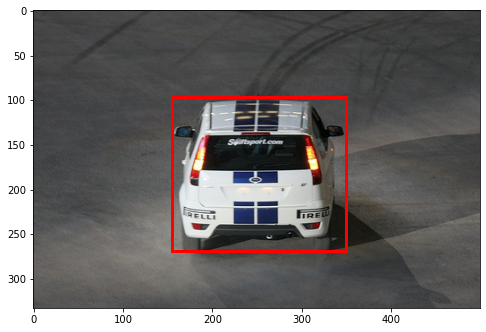

In [4]:
from torchvision import transforms

transfroms = transforms.Compose([
    transforms.ToTensor()
])

voc_data = PascalDataset(voc_root='./VOC2007/', image_set='train', transforms=transfroms)
voc_iter = iter(voc_data)
img, label = next(voc_iter)

print(img.shape, '\n', label)

img_PIL = transforms.ToPILImage()(img.clone())
bb_label = label['boxes']
draw_bb(img=img_PIL, boxes=bb_label)

## 3. Define Faster-RCNN

In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# doc: https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html

# load a model pre-trained pre-trained on COCO train 2017, COCO는 class 91개
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 21  #  class (20) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cls_logits): Conv2d(256, 15, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 60, kernel_size=(1, 1), stride=(1, 1))
  )
)

## 4. Fine-tune Faster-RCNN.

In [7]:
transfroms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalization value
])

# train on the GPU or on the CPU, if a GPU is not available
voc_train = PascalDataset(voc_root='./VOC2007/', image_set='train', transforms=transfroms)
voc_test = PascalDataset(voc_root='./VOC2007/', image_set='val', transforms=transfroms)

In [8]:
def collate_fn(batch):
    zip_batch = zip(*batch)
    tuple_batch = tuple(zip_batch)
    return tuple_batch


### define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    voc_train, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    voc_test, batch_size=16, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [9]:
res = [['a', 'b', 'c'], [1, 2, 3]]
tuple(zip(*res))

(('a', 1), ('b', 2), ('c', 3))

In [10]:
# move model to device
model = model.to(device)

# construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [11]:
# let's train it for 1 epochs
num_epochs = 30
# print loss every 10 mini-batches
print_step = 10

# train for one epoch, printing every 10 iterations
for epoch in range(num_epochs):
    ## enumerate through data_loader
    ### Train mode
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader_train):
        
        ### Load input data
        images = list(image.to(device) for image in images)        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        ### Forward & loss aggregation
        loss_dict = model(images, targets)
        
        ### 로스 종류 확인
        ### print(loss_dict.keys())
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
    
        ### BackPropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        ### print itermedicate outputs
        if(batch_idx % print_step == 0):
            print('Epoch: [{}/{}], Iterations: [{}/{}], loss: {}  '.format(epoch, num_epochs, batch_idx, len(data_loader_train), loss_value))

print('Training Done!')

Epoch: [0/30], Iterations: [0/157], loss: 3.760232448577881  
Epoch: [0/30], Iterations: [10/157], loss: 0.9429433941841125  
Epoch: [0/30], Iterations: [20/157], loss: 0.8687246441841125  
Epoch: [0/30], Iterations: [30/157], loss: 0.8381531238555908  
Epoch: [0/30], Iterations: [40/157], loss: 0.7383397221565247  
Epoch: [0/30], Iterations: [50/157], loss: 1.2593066692352295  
Epoch: [0/30], Iterations: [60/157], loss: 0.8519093990325928  
Epoch: [0/30], Iterations: [70/157], loss: 0.9553423523902893  
Epoch: [0/30], Iterations: [80/157], loss: 0.8297472596168518  
Epoch: [0/30], Iterations: [90/157], loss: 0.7599628567695618  
Epoch: [0/30], Iterations: [100/157], loss: 0.8458644151687622  
Epoch: [0/30], Iterations: [110/157], loss: 1.043543815612793  
Epoch: [0/30], Iterations: [120/157], loss: 0.8025355935096741  
Epoch: [0/30], Iterations: [130/157], loss: 0.8608819842338562  
Epoch: [0/30], Iterations: [140/157], loss: 0.754010796546936  
Epoch: [0/30], Iterations: [150/157], l

In [12]:
# predefined evaluation function
from engine import evaluate
#egg=pycocotools^&subdirectory=PythonAPI.
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/157]  eta: 0:02:12  model_time: 0.0771 (0.0771)  evaluator_time: 0.0302 (0.0302)  time: 0.8409  data: 0.7046  max mem: 2560
Test:  [100/157]  eta: 0:00:09  model_time: 0.0729 (0.0737)  evaluator_time: 0.0268 (0.0298)  time: 0.1637  data: 0.0423  max mem: 2560
Test:  [156/157]  eta: 0:00:00  model_time: 0.0701 (0.0734)  evaluator_time: 0.0265 (0.0290)  time: 0.1530  data: 0.0397  max mem: 2560
Test: Total time: 0:00:25 (0.1640 s / it)
Averaged stats: model_time: 0.0701 (0.0734)  evaluator_time: 0.0265 (0.0290)
Accumulating evaluation results...
DONE (t=1.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

## 5. Visulize the evaluation results.

In [13]:
# eval mode
model.eval();

In [14]:
data_it = iter(data_loader_test)

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.9841, 0.8549, 0.2811, 0.2116], device='cuda:0',
       grad_fn=<IndexBackward0>)
2


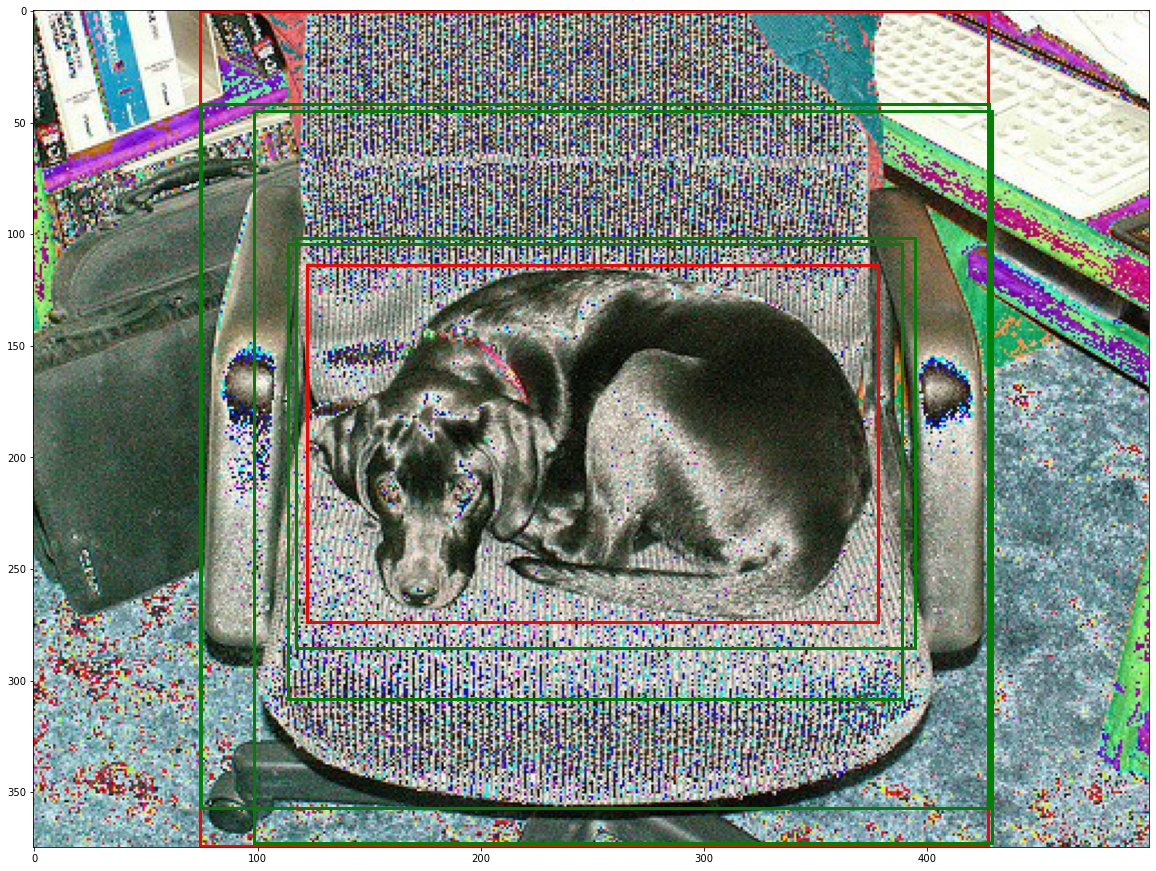

tensor([12,  9, 18,  8], device='cuda:0')
[[117.04773  101.927345 394.45963  285.29004 ]
 [ 74.42578   41.51902  427.73105  357.23483 ]
 [ 98.4277    44.878883 428.93546  372.6743  ]
 [113.727325 104.383286 388.5913   308.2267  ]]


In [22]:
imgs, labels = next(data_it)

img_test = imgs[0]
bbox_test = labels[0]['boxes']

prediction = model(list([img_test.to(device)]))
scores = prediction[0]['scores']
print(scores)
threshold = (scores>0.8).sum().cpu().detach().item()
print(threshold)
### transform for visulization
P = torchvision.transforms.ToPILImage()
img_test_PIL = P(img_test)
prediction_bbox_np = prediction[0]['boxes'].cpu().detach().numpy()#[:threshold]
draw_bb2(img_test_PIL, bbox_test, prediction_bbox_np)
print(prediction[0]['labels'])
print(prediction_bbox_np)

## (Optional) Test on an image you want.

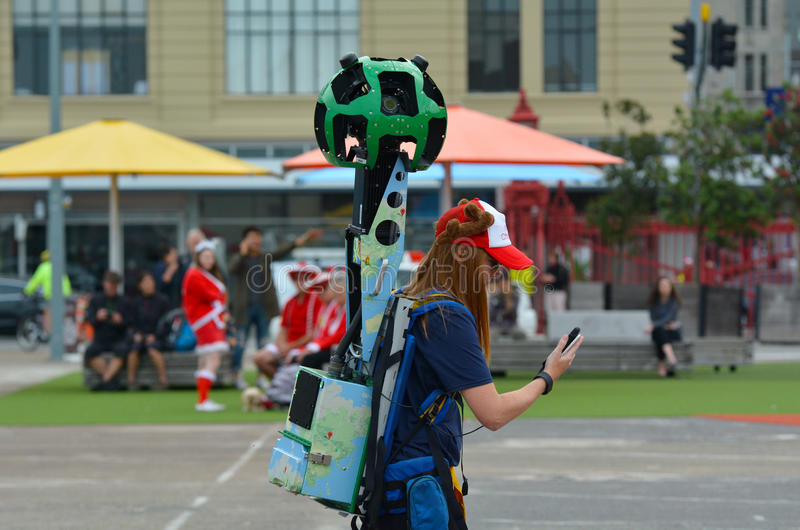

In [16]:
# read image
img_demo = Image.open('./sample.jpg').convert("RGB")
img_demo 

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.9714, 0.9355, 0.8912, 0.7182, 0.6218, 0.4973, 0.4295, 0.4219, 0.1609,
        0.0657, 0.0539])
tensor([0.9714, 0.9355, 0.8912, 0.7182, 0.6218, 0.4973, 0.4295, 0.4219, 0.1609])
tensor([15, 15, 15, 15, 15,  4, 15, 15, 15])
tensor([[277.0804,  55.0604, 573.7525, 530.0000],
        [653.7314, 276.8784, 685.9135, 377.1625],
        [360.2131, 238.0218, 569.8331, 508.0456],
        [247.1164, 231.2577, 290.8682, 385.3678],
        [173.3127, 226.6966, 240.2147, 407.5307],
        [252.6428,  66.6434, 564.3556, 507.1844],
        [728.6847, 288.3418, 753.6866, 358.4175],
        [736.3231, 286.0159, 770.2563, 358.5620],
        [ 19.5438, 254.4673,  73.8925, 359.2145]])


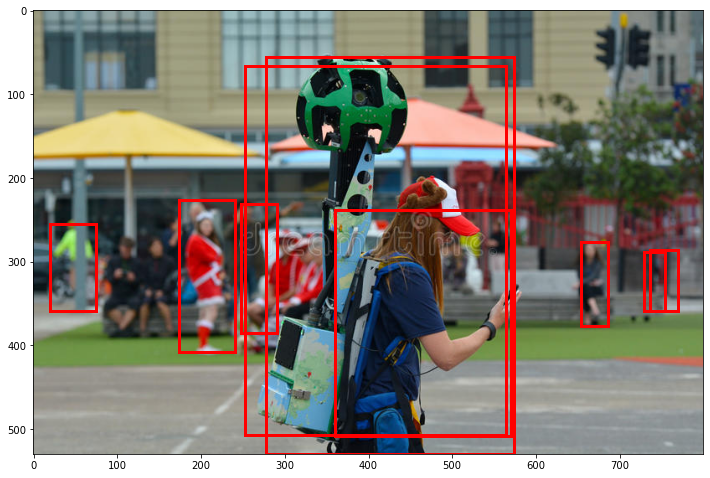

In [17]:
# Forward through trained model
bboxes_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['boxes'].cpu().detach()
scores_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['scores'].cpu().detach()
labels_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['labels'].cpu().detach()

threshold = (scores_demo>0.1).sum().item()

print(scores_demo)
print(scores_demo[:threshold])
print(labels_demo[:threshold])
print(bboxes_demo[:threshold])

# Draw bounding boxes
draw_bb(img_demo, bboxes_demo[:threshold], 'r', (12, 12))

In [18]:
def nms(boxes, scores, threshold):
    """
    boxes: (N, 4), each row-> (x1, y1, x2, y2), x2 > x1, y2 > y1
    scores: (N,), each value in [0, 1]
    threshold: iou threshold
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()
    
    keep = []
    
    while len(order) > 0:
        # the index with the highest score.
        idx = order[-1]
        # keep it.
        keep.append(boxes[idx])
        # remove the index from the candidate list.
        order = order[:-1]
        
        if len(order) == 0:
            break # check
        
        # order bounding boxes according to the order.
        xx1 = x1[order]
        xx2 = x2[order]
        yy1 = y1[order]
        yy2 = y2[order]
        
        # intersection coordinate
        ix1 = torch.max(xx1, boxes[idx, 0])
        iy1 = torch.max(yy1, boxes[idx, 1])
        ix2 = torch.min(xx2, boxes[idx, 2])
        iy2 = torch.min(yy2, boxes[idx, 3])
        
        # width and height of the intesection, calculate intersection
        w = torch.clamp(ix2-ix1, min=0.)
        h = torch.clamp(iy2-iy1, min=0.)
        
        inter = w*h
        rem_areas = areas[order] + areas[idx] - 2*inter
        union = rem_areas + inter
        iou = inter / union
        
        # keep the boxes with iou less than threshold
        order = order[iou<threshold]
        
    return keep

6


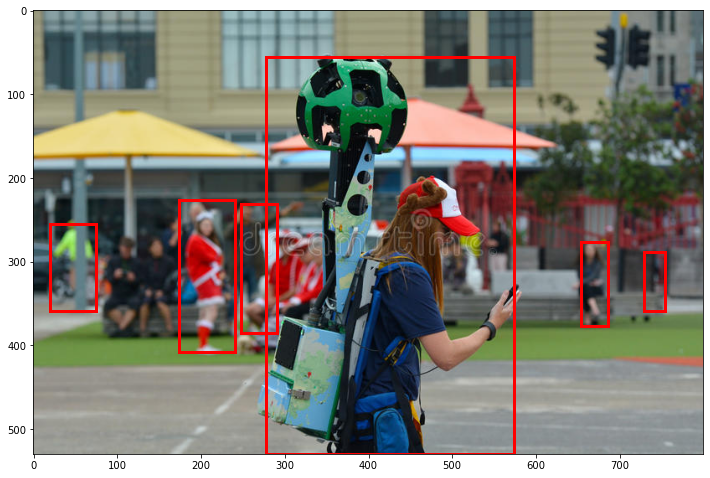

tensor([0.9714, 0.9355, 0.8912, 0.7182, 0.6218, 0.4973])
person
person
person
person
person
boat


In [21]:
classes = ('__background__',
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
indexes_to_classes = dict(zip(range(len(classes)), classes))
nms_boxes = nms(bboxes_demo[:threshold], scores_demo[:threshold], 0.3)
print(len(nms_boxes))
draw_bb(img_demo, nms_boxes, 'r', (12, 12))
print(scores_demo[:len(nms_boxes)])
for i in labels_demo[:len(nms_boxes)]:
    print(indexes_to_classes[i.item()])

In [ ]:
draw_bb(img_demo, bboxes_demo_np[:threshold], 'r', (12, 12))